# Dimensionality reduction

<div class='alert alert-block alert-info'>

Lesson time: 90 m   
Contributors: Davide Spalla

---
### In this lesson you will learn:
- What dimensionality reduction is and why it is useful in the analysis of neural data
- How to use Principal Component Analysis to obtain a low-dimensional description of the data
- How dimensionality reduction can be used to discover collective modes of activity in the brain
- You will get an overview of the most used non-linear dimensionality reduction methods

</div>


In [1]:
import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
# download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/uh8XZNenSfuR2fq')

## Introduction
---
 
Data is often high dimensional. In the case of neural data, scientists routinely have to make sense of the simultaneous activity of hundreds of recorded neurons.
Working with high dimensional data is difficult : we cannot visualize directly what is going on, and our statistical intuitions easily beak down (see, for example [the curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).  
However,the many dimensions in which the data live are often not independent. Neurons have common inputs and talk to each other, neighboring pixels and voxels in imaging data are highly correlated.  
Dimensionality reduction methods yield a low-dimensional description of the data that retains important information, so that we can make sense of it more easily.
Common uses of dimensionality reduction are: 
- visualization: to visualize the data in a 2D or 3D space and get an intuitive feeling of some underlying structure
- compression: to efficiently describe the data without loosing to much information
- Preprocessing: to prepare the data for further analysis
- analysis: to discover and study collective modes of variation in the data


## Principal Component Analysis
---

Principal component analysis is one of the most popular dimensionality reduction algorithms. It performs **linear orthogonal transformation** of the data space that finds the combinations of features that best explain the variability of the data. These combinations, called **principal components**, form a new coordinate system for the data, such that the coordinates are ranked by explained variance and are orthogonal (uncorrelated) with each other.  

Here is a brief overview of how PCA works:  
Let's consider a $N\times P$ data matrix $X$ with $P$ features and $N$ observations (often referred to as "samples" in the data science literature).  
These are $N$ points $x_{i}$ in a  $P$-dimensional space.  

To find the first principal component, the algorithm looks for a $P$-dimensional weight vector $w_{1}$, with unit norm ($|w_{1}=1|$), such that the sum of the projections of the $N$ observed points $x_{i}$ in the direction $w_{1}$ is maximal:

$$ w_{1}=\underset{|w|=1} {argmax}\left[  \sum_{i=1}^{N}(x_{i} \cdot w)^{2} \right] = \underset{|w|=1} {argmax}\left[ w^{T}X^{T}Xw \right] $$

This finds the first principal component $w_{1}$, i.e. the direction of maximal variability in the feature space.  
We can repeat the procedure to find a second direction $w_{2}$, that maximizes variability on the $P-1$ dimensional subspace  $\hat{X}$ orthogonal to $w_{1}$.
We first find $\hat{X}$ by subtracting the first principal component from $X$:

$$ \hat{X}= X -Xw_{1}w_{1}^{T} $$

And then find $w_{2}$ maximizig projections in $\hat{X}$:

$$ w_{2} = \underset{|w|=1} {argmax}\left[ w^{T}\hat{X}^{T}\hat{X}w \right] $$

Repeating the procedure, we can iteratively found an orthonormal basis for the features space, in which dimensions are ranked by how variable the observed data are along them.
This ranking can be used to reduce the dimensionality of the data: we can decide to retain only the first $L$ components ($L<P$), we obtain a $L$ dimensional description of $X$. The PCA procedure guarantees that this representation i the one that captures the most variance of the data, given $L$.

### PCA in action: compressing images
Let's look at the principal component analysis in action: we will compute the PCs for the popular MNIST dataset of hand-written digits.  
First, let's load and visualize the dataset:

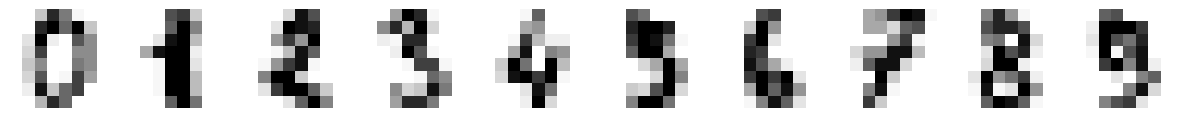

In [3]:
# load image data
dataset = load_digits()
images = dataset.data

#plot first 10 images
plt.figure(figsize=(15,7))
for i,img in enumerate(images[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')
    


These are 16 x 16 pixels images. You can think of each image as of a data point in a 64-dimensional space.
However, these 64 dimensions are not independent: we can exploit the correlation structure to find the patterns that explain the most variance, and use those patterns to obtain a compressed representation of the images.

First, let's scale our data: we don't want a certain dimension to dominate our decomposition only because it's values are measured in a larges scale, so we z-score our variable by substituting $x_{i}$ with 
$$z_{i}=\frac{x_{i}-\mu_{i}}{\sigma_{i}}$$
where $\mu_{i}$ and $\sigma_{i}$ are the mean and variance of the variable $i$ across the dataset.

In [4]:
# defines a scaler objects
scaler = StandardScaler()
# z-score with fit_transform method
X =scaler.fit_transform(images)

Then we perform the PCA: we define a PCA object and call the `fit()` method on the data to compute the components and their eigenvalues.

In [5]:
pca = PCA()
pca.fit(X)

PCA()

Let's plot the explained variance ratio of each component and it's cumulative (the fraction of total variance that is explained if we retain a given number of components)

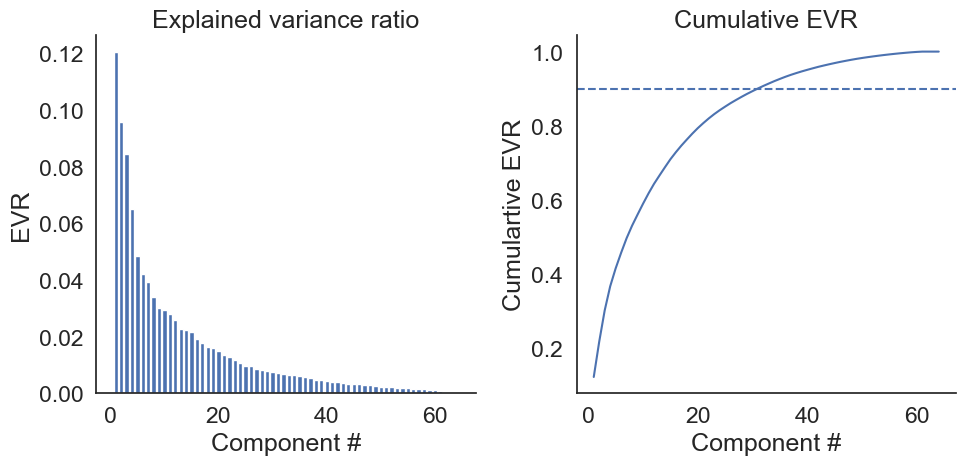

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Explained variance ratio')
plt.xlabel('Component #')
plt.ylabel('EVR')
plt.bar(np.arange(1,len(pca.components_)+1),pca.explained_variance_ratio_)

plt.subplot(1,2,2)
plt.title('Cumulative EVR')
plt.xlabel('Component #')
plt.ylabel('Cumulartive EVR')
plt.plot(np.arange(1,len(pca.components_)+1),np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9,linestyle='--')

plt.tight_layout()

We can appreciate how we can explain more than 90% of the variance with roughly half of the total number of component: we can describe the data with half the number of variable, without loosing hardly any useful information.

Let's see how the first 10 component look

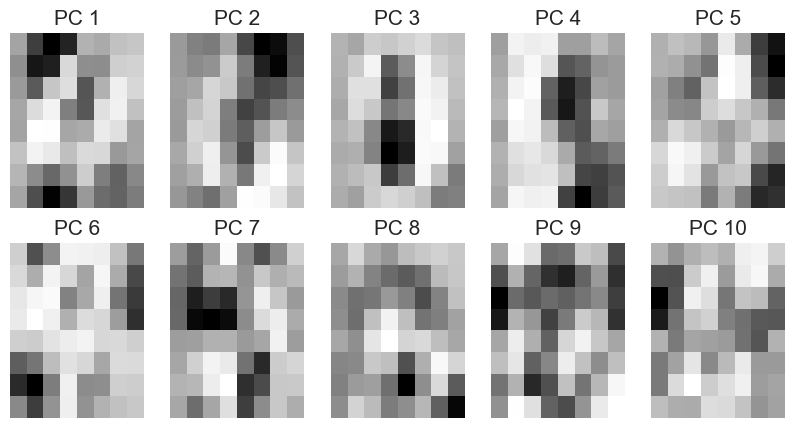

In [7]:
plt.figure(figsize=(10,5))
for i,component in enumerate(pca.components_[:10]):
    plt.subplot(2,5,i+1)
    plt.title(f'PC {i+1}',fontsize=15)
    plt.imshow(component.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')

Each component correspond to a spatial pattern. You can recognize some pieces of the digits: PCA is picking up some of the structure in the image dataset.  
What happens if we project the dataset on the two dimensional space spanned by the first two PCs? This allows us to visualize the full image dataset in a single plot. Below we do exactly that, by fitting a PCA with only two component and transforming the data in the fitted space (all this is done with the `fit_transform()` method).   
We can color the point with their labels, such that images of the same number will have the same color.

Text(0, 0.5, 'PC2')

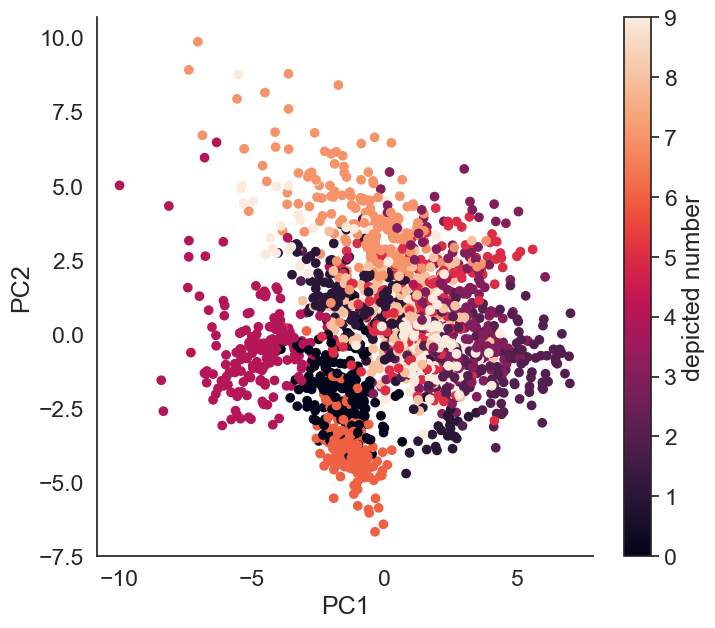

In [8]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.figure(figsize=(8,7))
plt.scatter(X_2d[:,0],X_2d[:,1],c=dataset.target)
plt.colorbar(label='depicted number')
plt.xlabel('PC1')
plt.ylabel('PC2')

As you can see, many numbers (not all) can be distinguished by only looking at the first two PCs: this is a $1-2/64 = 97\%$ compression.

Let's see what we can do if we retain 32 (half) of the components: we'll fit the PCA, project the images in the 32-dimensional space, and then try to reconstruct the original image by inverse projection and inverse scaling.
You can think of this a lossy compression of a file, followed by its reconstruction.

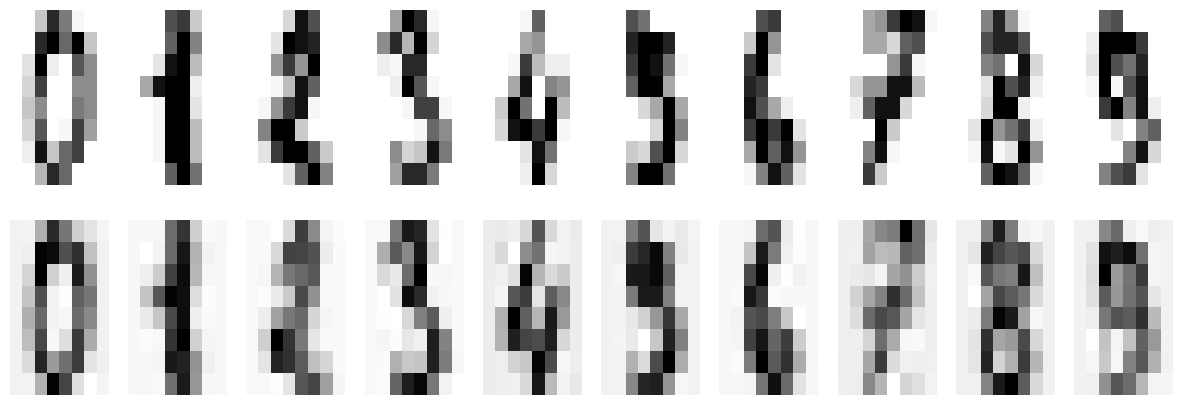

In [9]:
pca = PCA(n_components=32)
X_reduced = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_reduced)

reconstructed_images = scaler.inverse_transform(X_reconstructed)

n_examples = 10 
plt.figure(figsize=(15,5))
for i,(img,r_img) in enumerate(zip(images[:n_examples],reconstructed_images[:n_examples])):
    plt.subplot(2,n_examples,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')

    plt.subplot(2,10,i+11)
    plt.imshow(r_img.reshape(8,8),cmap=plt.cm.Greys,aspect='auto')
    plt.axis('off')





The number are quite readable: we have retained enough information to allow the human eye to distinguish the images, using half of the original dimensions.  
This gain will be even more dramatic for higher resolution images, where the correlation structure is even stronger.
But let's now do some neuroscience.

### Example: discovering collective modes of cortical activity
---
As an example, we will look at how PCA can help us discover collective mode of activity in the mouse cortex.
Here you see a gif of the activity recorded from the dorsal right emisphere of a mouse, using [voltage sensitive dye imaging](https://www.mdpi.com/1422-0067/23/12/6814).


<img src="imgs/cortical_activity.gif" width="600">


As you can see, the activity in each pixel is very correlated: nearby pixel will show similar activation patterns, and some long-range correlations seem to be present as well.
Let's use PCA to exploit this correlation and obtain a low-d description of the data.

First, let's import the data.
- `trial_data` is a dictionary containing the behavioural data: `CSp` and `CSn` contain the time onsets of the two auditory stimuli, `Lick` contains the lick times and `frames` the time index of the frames of the voltage signal, to aling the neural data to the behaviour.
- `voltage_signal` is a numpy array containing the multivariate voltage signal
- `cortex_mask` is a boolean mask that marks `True` the pixels of the voltage signal images belong to the cortex, and `False` the background ones.

In [10]:
import pickle

with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_44153/3011701182.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  trial_data = pickle.load(handle)


In [11]:
voltage_signal.shape

(96, 61, 29999)

Let's prepare the data for the PCA

In [28]:
X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image

In [29]:
X.shape

(29999, 3029)

We can now perform the PCA. We'll extract the first 50 components.

In [13]:
pca = PCA(n_components=50);
pca.fit(X)

PCA(n_components=50)

Text(0, 0.5, 'EVR')

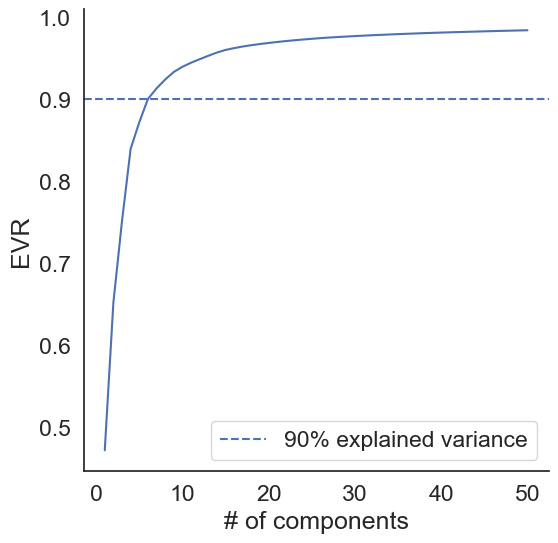

In [14]:
evr = pca.explained_variance_ratio_
c_evr = np.cumsum(evr)
plt.figure(figsize=(6,6))
plt.axhline(0.9,linestyle='--',label='90% explained variance')
plt.plot(range(1,len(c_evr)+1),c_evr)
plt.legend()
plt.xlabel('# of components')
plt.ylabel('EVR')

With 10 components we retain more than 90% of the variance of the data: we can use these 10 components to study the behaviour of the collective behaviour of the cortex.

Let's plot the topographic organzation of the weights of these ten component, to appreciate what areas of the cortex they relate to. 

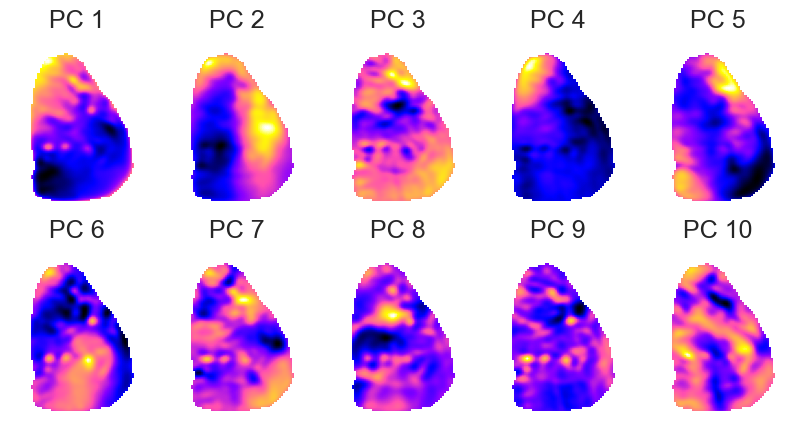

In [15]:
PCs = pca.components_[:10]

plt.figure(figsize=(10,5))
for i, pc in enumerate(PCs):
    plt.subplot(2,5,i+1)
    plt.title(f'PC {i+1}')
    reshaped_pc = np.full((h,w),np.nan)
    reshaped_pc[np.where(cortex_mask)] = pc
    plt.imshow(reshaped_pc,aspect='auto',cmap=plt.cm.gnuplot2)
    plt.axis('off')
    

Some components are spatially localized to specific areas, while other look more distributed.  
We can look at the component activation timecourse, relative to the onset of some behavioural event.  
Let's, for instance, look at component 8. It is mostly localized around a motor area, so we can look at what happens with it around licking times, which have a motor component.

In [16]:
from scipy.stats import sem

PCs = pca.components_[:10,:].T # select and transpose first 10 PCs weights
Y = X @ PCs # compute the PC timecourse, by projecting the original data on each component

framerate = 50. #in Hz
start_time = -1. #seconds, relative to lick onset
end_time = 2. #seconds, relative to lick offset

frame_times = trial_data['frames'] #frame times

peri_Y = [] #empty list for peri-lick timecourses

#cycle over licking onsets
for i in trial_data['Lick']:
    onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
    start_frame = int(onset_frame + framerate*start_time/1.000) # compute starting frame
    end_frame = int(onset_frame + framerate*end_time/1.000) # compute ending frame
    peri_Y.append(Y[start_frame:end_frame]) #saves the slice of Y

peri_Y = np.asarray(peri_Y) 

mean_Y = np.mean(peri_Y,axis=0) #average over licks
error = sem(peri_Y,axis=0) #compute sem over licks

Let's plot the timecourse of component 8 around the licks

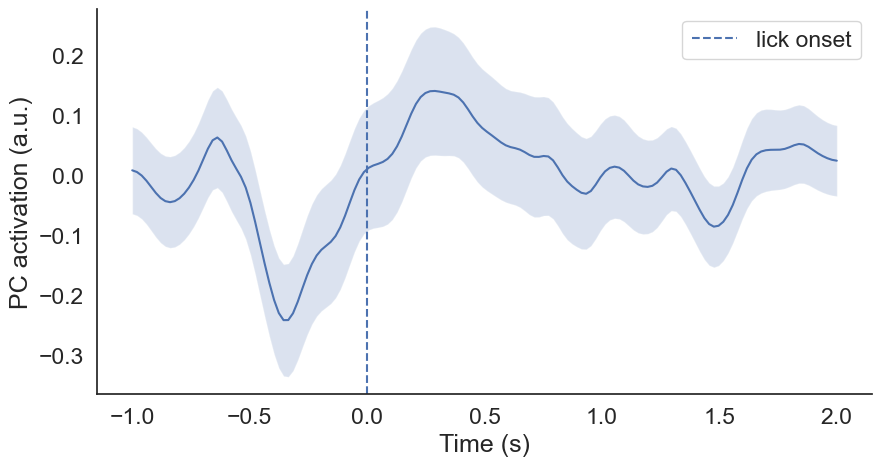

In [17]:
from scipy.ndimage import gaussian_filter1d

comp = 8 #component to plot

plt.figure(figsize=(10,5))
t = np.linspace(start_time,end_time,int((end_time-start_time)*framerate))
y = mean_Y[:,comp-1]
err = error[:,comp-1]

y = gaussian_filter1d(y,2)
err = gaussian_filter1d(err,2)

plt.plot(t,y)
plt.fill_between(t,y-err,y+err,alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('PC activation (a.u.)')

plt.axvline(x=0,linestyle='--',label='lick onset')
plt.legend()
#plt.axvline(x=2,linestyle='--')
#plt.axvline(x=3,linestyle='--')

Component eight shows a swing in its activity around lick onset: from a negative deflection, maybe in preparation, to a positive peak after the lick. 
Be careful: this selectivity should not be inferred just by looking at the timecourse: we should compare the observed result with what would be expected in a statistical null case.

Still, we have now a handful of independent variables, our principal components, that we can associate to a particular spatial profile on the cortex, and we can study their temporal profiles and their selectivity to different behavioural features.

Let's now move beyond PCA, and take a brief look at some other popular dimensionality reduction methods.

## Non-linear dimensionality reduction
---

Principal component analysis helps us find the *linear subspace* that maximizes the variance of the data, given a dimension.
This method is powerful, but has its limitations: data can be organized in subspaces that have more complex shapes ad curvatures, that PCA will fail to capture.
Other dimensionality reduction methods can overcome this limitation, by changing the requirements they impose on the embedding subspace. We will see here an overview of some popular methods, each with its own assumptions, strengths and limitations:


### Multidimensional scaling (MDS)

[Multidimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) tries to embed the high dimensional data points in a low-dimensional space of a given dimension $D$, in a way that best preserves the pairwise distances between the points.
MDS computes the embedding coorinates $x_{i} \in \mathbf{R}^{D}$ such that the total distortion of the pairwise differences (usually called [strain]() or stress) is minimized.
The most intuitive version, called metric MDS, minimizes the loss function:

$$Stress_{D} = \sqrt{\sum_{i \neq j=1-N}(d_{ij}-||x_{i}-x_{j}||)^{2}} $$

MDS minimizes the *global* distorsion, it does not take into account neighbouring relationships (for example weighting differently small and large distances)

### t-SNE
[t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a dimensionality reduction methods mostly used to visualize high-dimensional datasets.

First, tSNE computes the probability of the point $i$ having $j$ as his neighbour as:
$$p_{i|j}=\frac{\exp(-||x_{i}-x_{j}||^{2}/2\sigma_{i}^{2})}{\sum_{k \neq i} \exp(-||x_{i}-x_{k}||^{2}/2\sigma_{i}^{2})}$$
Where $x$ are the coordinates in the original high-dimensional space and $\sigma_{i}$ is a length scale parameters, optimized by the algorithm for each datapoint by fixing the entropy of all conditional distributions to be the same (you can think of the algorithm as adapting $\sigma$ to match the local density of the data).

Once these conditional probabilities are computed, pairwise similarities $p_{jj}$ are computed as:
$$p_{ij}=\frac{p_{i|j}+p_{j|i}}{2N}$$
Where $N$ is the number of data points.

Finally, the algorithm computes a set of coordinates $y_{i}$ in a space of given, lower dimensionality (usually 2 or 3 to allow visualization).
These coordinates are set to have similarities $q_{ij}$ given by:
$$q_{ij}=\frac{(1+||y_{i}-y_{j}||^{2})^{-1}}{\sum_{k,l,l \neq k}(1+||y_{i}-y_{j}||^{2})^{-1}}$$
Which is the same procedure as before, but using a Student t-distribution (hence the name of the method) to asses neighbourhood probabilities.

The mapping between the orignial $x_{i}$ and the embedded $y_{i}$ is found minimizing the Kullback-Leibler divergence between the two distributions:

$$KL(P||Q)=\sum_{i \neq j}p_{ij}\log \frac{p_{ij}}{q_{ij}}$$

<div class="alert alert-block alert-warning"> 

### Do not over-interpret tSNE plots
The tSNE algorithm has a tendency to show clusters in data, and the size, number and distribution of these clusters can strongly depend on the specific hyperparameter choice.  Moreover, tSNE can sometime produce strongly clustered embeddings from non-clustered original data.  
Be mindful that tSNE (and other dimensionality reduction methods) visualizations can be misleading: always validate any effect by see how it changes with different hyperparameters and, more importantly, with quantitative measure of clustering and similarity.



### Isomap
[Isomap](https://en.wikipedia.org/wiki/Isomap) extends Multidimensional Scaling by incorporating neighbourhood information: it works on the geodesic distances of a weighted graph instead that on all-to-all euclidean distances.

Broadly speaking, the step for Isomap are the following:
- Determine the neighbours of each point (this can be done by fixing a neighbourhood radius $R$, or a number of neighbours $K$)
- Construct a graph by connecting each neighbour pair, with a weight proportional to their euclidean distances
- Compute the distances $d_{ij}$ as the lenght of the shortes path on the graph between $i$ and $j$
- Compute the embeddings by using MDS with the distances $d_{ij}$

Isomap explicitly weighs the *local* information more than MDS, by focusing on the shortest distances and allowing only paths between distant points that pass through other, in between points.
The parameter $R$ or $K$, depending on the implementation, regulate this balance: in the limit in which they are very large, the graph will become fully connected and Isomap will reduce to MDS.



Let's compare what these method give, for the digits images

In [18]:
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap


# load and preprocess data
dataset = load_digits()
images = dataset.data
X = StandardScaler().fit_transform(images)

# initialize embedding calculator
mds = MDS(n_components=2,random_state=0,normalized_stress='auto')
tsne = TSNE(n_components=2,random_state=0)
isomap = Isomap(n_components=2)

#fit emebddings and transform data
X_mds = mds.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_iso = isomap.fit_transform(X)


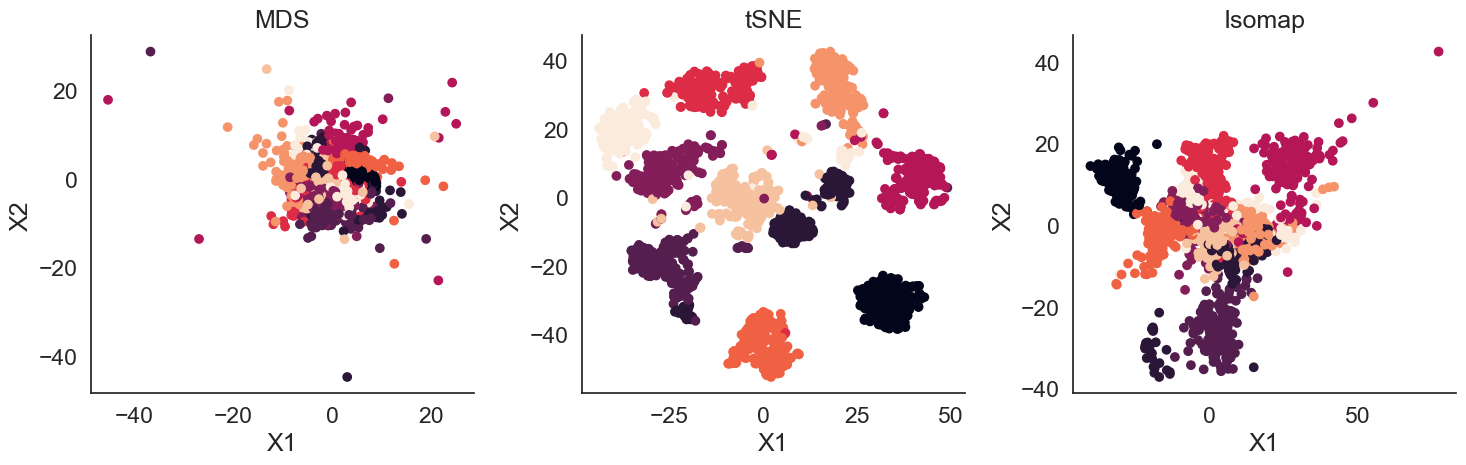

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_mds[:,0],X_mds[:,1],c=dataset.target)
plt.title('MDS')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=dataset.target)
plt.title('tSNE')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_iso[:,0],X_iso[:,1],c=dataset.target)
plt.title('Isomap')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()

As you can appreciate, the different methods can return quite different results. These will also change depending on the hyperparameters you are using. It is very important to be aware of the assumptions behind each technique, and remember that nonlinear dimensionality reduction tools are mostly useful for visualization: any conclusion drawn from this plot should be checked with appropriate quantitative measures and comparisons with null cases.

<div class='alert alert-block alert-info'>

### Key points 

- PCA performs a linear transformation on the data space, such that the axis of the new basis are ordered by decreasing explained variance
- PCA can help to obtain a lower-dimensional description of high-dimensional, correlated data
- We can use PCA to find correlated modes of activity in imaging data, and use this components to compactly study cortical responses to external stimuli or events.
- MDS,tSNE and Isomap are popular non-linear dimensionality reduction methods, that embed the data in low-d space trying to preserve pairwise similarities.
- Dimensionality reduction methods and the visualization they produce should not be used to infer structure in the data without quantitative measures and null-case comparisons.

<div class='alert alert-block alert-info'>

### References and resources

**Books**
* [The elements of statistical learning](https://hastie.su.domains/ElemStatLearn/#:~:text=Elements%20of%20Statistical%20Learning%3A%20data%20mining%2C%20inference%2C%20and%20prediction.), chapter 14

**Web**
* [PCA wiki](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [PCA, video lesson](https://www.youtube.com/watch?v=fkf4IBRSeEc&t=22s)


## Exercises
You can find the exercises for this lessons in [exercises.ipynb](exercises.ipynb)